<a href="https://colab.research.google.com/github/eli-vigneron/toronto-parking-analysis/blob/main/toronto_ward_neighbourhood_analysis_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toronto Parking Infractions (#3)

In this notebook we will look at the following:

* Count by ward
* Sum fines by ward
* Any relevant demographic profiles of areas infractions take place

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
%matplotlib inline

Load the data

In [ ]:
# kaggle key (datasets are stored on kaggle)
data = {"username":"YOUR USERNAME","key":"YOUR KEY"}

with open('kaggle.json', 'w') as fp:
    json.dump(data, fp)

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d elivigneron/toronto-wards
! kaggle datasets download -d elivigneron/parking-tickets-top-20
! kaggle datasets download -d elivigneron/toronto-neighborhoods

In [ ]:
! mkdir '../input'
! unzip '/content/toronto-wards.zip' -d '../input/toronto-wards/'
! unzip '/content/parking-tickets-top-20.zip' -d '../input/parking-tickets-top-20/'
! unzip '/content/toronto-neighborhoods.zip' -d '../input/toronto-neighborhoods/'

Need to build a function that takes in a coordinate and returns the ward it is in

In [ ]:
import json
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point

def ward_locator(geojson_path, lon, lat):
    
    # load GeoJSON file containing sectors
    with open(geojson_path) as f:
        js = json.load(f)

        # construct point based on lon/lat returned by geocoder
        point = Point(lon, lat)

        # check each polygon to see if it contains the point
        for feature in js['features']:
            polygon = shape(feature['geometry'])
            if polygon.contains(point):
                ward = feature['properties']['AREA_NAME']
                
    return ward

In [ ]:
# test
ward_locator('../input/toronto-wards/City Wards Data.geojson', -79.23174554, 43.78421859)

'Scarborough-Guildwood'

Add these wards to the locations

In [ ]:
top_locations = pd.read_csv('../input/parking-tickets-top-20/top_locations.csv')

geo_j = '../input/toronto-wards/City Wards Data.geojson'

top_locations['Ward'] = top_locations.apply(lambda x: ward_locator(geo_j, x.Longitude, x.Latitude), axis=1)

In [ ]:
top_locations.head(5)

,location2,province,city_coord,address,coords,Latitude,Longitude,Ward
0,2075 Bayview Avenue,"TORONTO, ON","2075 Bayview Ave, North York, Toronto, Ontario...","2075 Bayview Ave, North York, Toronto, Ontario...","(43.72149001514609, -79.37880999379736)",43.721490,-79.378810,Don Valley West
1,20 Edward Street,"TORONTO, ON","20 Edward St, Toronto, Ontario, M5G 1C9","20 Edward St, Toronto, Ontario, M5G 1C9","(43.65706000181709, -79.38218999625286)",43.657060,-79.382190,University-Rosedale
2,1750 Finch Avenue E,"TORONTO, ON","1750 Finch Ave E, North York, Toronto, Ontario...","1750 Finch Ave E, North York, Toronto, Ontario...","(43.793940936254224, -79.34940231257131)",43.793941,-79.349402,Don Valley North
3,James Street,"TORONTO, ON","James St, Toronto, Ontario, M5G","James St, Toronto, Ontario, M5G","(43.65307234392041, -79.38109946360196)",43.653072,-79.381099,Toronto Centre
4,1265 Military Trl,"TORONTO, ON","1265 Military Trl, Scarborough, Toronto, Ontar...","1265 Military Trl, Scarborough, Toronto, Ontar...","(43.78547081980686, -79.18607639029766)",43.785471,-79.186076,Scarborough-Rouge Park


Now we can get the count and the sum of fines by ward

In [ ]:
top_20_count_total = pd.read_csv('../input/parking-tickets-top-20/top_20_count_total.csv')
top_20_rev_total = pd.read_csv('../input/parking-tickets-top-20/top_20_revenue_total.csv')

In [ ]:
top_20_count_total

,location2,count
0,2075 Bayview Avenue,111733
1,20 Edward Street,66580
2,1750 Finch Avenue E,52971
3,James Street,36384
4,1265 Military Trl,20638
5,25 The West Mall,19861
6,25 St Mary Street,19538
7,941 Progress Avenue,19469
8,1 Brimley Road S,19162
9,40 Orchard View Boulevard,18938


### Count by Ward

In [ ]:
top_20_count_total = top_20_count_total.merge(top_locations[['location2', 'Ward']],
                                              on='location2', how='left')
top_20_count_total.groupby('Ward').sum()

,count
Ward,
Don Valley North,70320
Don Valley West,111733
Eglinton-Lawrence,50484
Etobicoke-Lakeshore,35122
Parkdale-High Park,14263
Scarborough Southwest,19162
Scarborough-Guildwood,19469
Scarborough-Rouge Park,20638
Spadina-Fort York,41025


### Sum of Fines by Ward

In [ ]:
top_20_rev_total = top_20_rev_total.merge(top_locations[['location2', 'Ward']],
                                              on='location2', how='left')
top_20_rev_total.rename(columns={'count': 'revenue'}, inplace=True)
top_20_rev_total.groupby('Ward').sum()

,revenue
Ward,
Don Valley East,1676830.0
Don Valley North,684310.0
Don Valley West,3093026.0
Eglinton-Lawrence,4050668.0
Etobicoke North,1259490.0
Scarborough Southwest,2584975.0
Spadina-Fort York,3366305.0
Toronto Centre,3722167.0
University-Rosedale,7999752.0


### Relevant Demographic Profiles

Now we want to get the neighbourhoods for the top locaitons so that we can look at the demographics

In [ ]:
ward_locator('../input/toronto-neighborhoods/toronto_nbhds.geojson', -79.23174554, 43.78421859)

'Woburn (137)'

In [ ]:
geo_j_2 = '../input/toronto-neighborhoods/toronto_nbhds.geojson'

top_locations['Neighbourhood'] = top_locations.apply(lambda x: ward_locator(geo_j_2, x.Longitude, x.Latitude), axis=1)

In [ ]:
top_locations.head(3)

,location2,province,city_coord,address,coords,Latitude,Longitude,Ward,Neighbourhood
0,2075 Bayview Avenue,"TORONTO, ON","2075 Bayview Ave, North York, Toronto, Ontario...","2075 Bayview Ave, North York, Toronto, Ontario...","(43.72149001514609, -79.37880999379736)",43.721490,-79.378810,Don Valley West,Bridle Path-Sunnybrook-York Mills (41)
1,20 Edward Street,"TORONTO, ON","20 Edward St, Toronto, Ontario, M5G 1C9","20 Edward St, Toronto, Ontario, M5G 1C9","(43.65706000181709, -79.38218999625286)",43.657060,-79.382190,University-Rosedale,Bay Street Corridor (76)
2,1750 Finch Avenue E,"TORONTO, ON","1750 Finch Ave E, North York, Toronto, Ontario...","1750 Finch Ave E, North York, Toronto, Ontario...","(43.793940936254224, -79.34940231257131)",43.793941,-79.349402,Don Valley North,Hillcrest Village (48)


In [ ]:
top_20_count_total = top_20_count_total.merge(top_locations[['location2', 'Neighbourhood']],
                                              on='location2', how='left')
top_20_count_total.groupby('Neighbourhood').sum()

,count
Neighbourhood,
Annex (95),14552
Bay Street Corridor (76),156112
Bayview Village (52),17349
Bridle Path-Sunnybrook-York Mills (41),111733
Cliffcrest (123),19162
High Park-Swansea (87),14263
Highland Creek (134),20638
Hillcrest Village (48),52971
Islington-City Centre West (14),19861


In [ ]:
count_nhd = top_20_count_total.groupby('Neighbourhood').sum().reset_index()

In [ ]:
top_20_rev_total = top_20_rev_total.merge(top_locations[['location2', 'Neighbourhood']],
                                              on='location2', how='left')
top_20_rev_total.groupby('Neighbourhood').sum()

,revenue
Neighbourhood,
Banbury-Don Mills (42),1676830.0
Bay Street Corridor (76),7296614.0
Bridle Path-Sunnybrook-York Mills (41),2413296.0
Cliffcrest (123),2584975.0
Don Valley Village (47),684310.0
Kensington-Chinatown (78),3261150.0
Thorncliffe Park (55),679730.0
University (79),3124470.0
Waterfront Communities-The Island (77),1405990.0


In [ ]:
rev_nbhd = top_20_rev_total.groupby('Neighbourhood').sum().reset_index()

In [ ]:
# load in the demographics csv which is based on 2011 and downloaded from Wellbeing Toronto
demographics = pd.read_csv('../input/demographics-2011/demographics.csv')
demographics.head()

,Neighbourhood,Hood#,Total Population,Child0-14,Youth15-24,Seniors65,Total visible minority population,Unemployed,Not in the labour force,"Total population aged 15 years and over by highest certificate, diploma or degree",...,Pop - Males,Less than grade 9,Average Family Income,Walk Score,TTC Stops,Road Volume,Road Kilometres,Pedestrian/Other Collisions,Traffic Collisions,Home Prices
0,West Humber-Clairville,1,34100,5970,5405,4305,26475,1750,9755,27365,...,17095,6170,72820,57,338,5956.638889,165.007379,727,778,317508
1,Mount Olive-Silverstone-Jamestown,2,32790,7665,5020,2945,28175,2175,10320,24980,...,16015,6855,57411,61,70,3514.166667,33.867318,224,154,251119
2,Thistletown-Beaumond Heights,3,10140,1825,1350,1745,6285,530,3315,8135,...,4920,1970,70838,54,45,3545.000000,27.876820,109,69,414216
3,Rexdale-Kipling,4,10485,1585,1315,1915,4425,590,3330,8600,...,5035,2095,69367,58,40,7621.333333,25.237129,62,96,392271
4,Elms-Old Rexdale,5,9550,2110,1380,1095,5510,575,2850,7495,...,4615,2025,61196,48,29,4115.500000,17.078211,63,70,233832


In [ ]:
rev_nbhd.head(3)

,Neighbourhood,revenue,Nbhd Number
0,Banbury-Don Mills (42),1676830.0,42
1,Bay Street Corridor (76),7296614.0,76
2,Bridle Path-Sunnybrook-York Mills (41),2413296.0,41


In [ ]:
# extract the nbhd numbers
rev_nbhd['Nbhd Number'] = rev_nbhd['Neighbourhood'].str.extract('.*\((.*)\).*', expand=True)

In [ ]:
# cast as int
rev_nbhd['Nbhd Number'] = rev_nbhd['Nbhd Number'].astype('int64')

In [ ]:
# extract the nbhd numbers
count_nhd['Nbhd Number'] = count_nhd['Neighbourhood'].str.extract('.*\((.*)\).*', expand=True)

In [ ]:
# cast as int
count_nhd['Nbhd Number'] = count_nhd['Nbhd Number'].astype('int64')

In [ ]:
# add the demographic info
rev_nbhd_dems = rev_nbhd.merge(demographics, how='left', left_on='Nbhd Number', right_on='Hood#')

In [ ]:
count_nbhd_dems = count_nhd.merge(demographics, how='left', left_on='Nbhd Number', right_on='Hood#')

In [ ]:
rev_nbhd_dems.head()

,Neighbourhood_x,revenue,Nbhd Number,Neighbourhood_y,Hood#,Total Population,Child0-14,Youth15-24,Seniors65,Total visible minority population,...,Pop - Males,Less than grade 9,Average Family Income,Walk Score,TTC Stops,Road Volume,Road Kilometres,Pedestrian/Other Collisions,Traffic Collisions,Home Prices
0,Banbury-Don Mills (42),1676830.0,42,Banbury-Don Mills,42,26910,3710,2720,6095,11935,...,12485,2300,115239,67,128,4750.642857,75.068163,319,166,613647
1,Bay Street Corridor (76),7296614.0,76,Bay Street Corridor,76,19345,1375,3740,1805,10555,...,9315,695,90324,99,126,4701.100000,26.299757,580,290,457787
2,Bridle Path-Sunnybrook-York Mills (41),2413296.0,41,Bridle Path-Sunnybrook-York Mills,41,8715,1410,1360,1510,1965,...,4180,630,356777,58,66,7224.500000,48.365086,205,128,1849084
3,Cliffcrest (123),2584975.0,123,Cliffcrest,123,15700,2650,2110,2410,5545,...,7645,2380,83694,54,69,3779.625000,51.387128,97,108,542218
4,Don Valley Village (47),684310.0,47,Don Valley Village,47,26735,4160,3375,4140,18195,...,12670,2665,69884,79,57,6050.300000,39.986169,251,185,478489


In [ ]:
# sort by count and revenue
count_nbhd_dems = count_nbhd_dems.sort_values('count', ascending=False)
rev_nbhd_dems = rev_nbhd_dems.sort_values('revenue', ascending=False)

In [ ]:
count_nbhd_dems.head(3)

,Neighbourhood_x,count,Nbhd Number,Neighbourhood_y,Hood#,Total Population,Child0-14,Youth15-24,Seniors65,Total visible minority population,...,Pop - Males,Less than grade 9,Average Family Income,Walk Score,TTC Stops,Road Volume,Road Kilometres,Pedestrian/Other Collisions,Traffic Collisions,Home Prices
1,Bay Street Corridor (76),156112,76,Bay Street Corridor,76,19345,1375,3740,1805,10555,...,9315,695,90324,99,126,4701.100000,26.299757,580,290,457787
3,Bridle Path-Sunnybrook-York Mills (41),111733,41,Bridle Path-Sunnybrook-York Mills,41,8715,1410,1360,1510,1965,...,4180,630,356777,58,66,7224.500000,48.365086,205,128,1849084
7,Hillcrest Village (48),52971,48,Hillcrest Village,48,17650,2100,2480,3830,12525,...,8240,1985,81484,68,80,3566.222222,41.084554,170,174,484743


In [ ]:
# take a look at the correlations
correls = count_nbhd_dems[count_nbhd_dems.columns[1:]].corr()['count'][:-1]
correls = correls.to_frame()
correls

,count
count,1.000000
Nbhd Number,-0.171976
Hood#,-0.171976
Total Population,-0.292438
Child0-14,-0.307109
Youth15-24,-0.057516
Seniors65,-0.406079
Total visible minority population,-0.109792
Unemployed,-0.204829
Not in the labour force,-0.205464


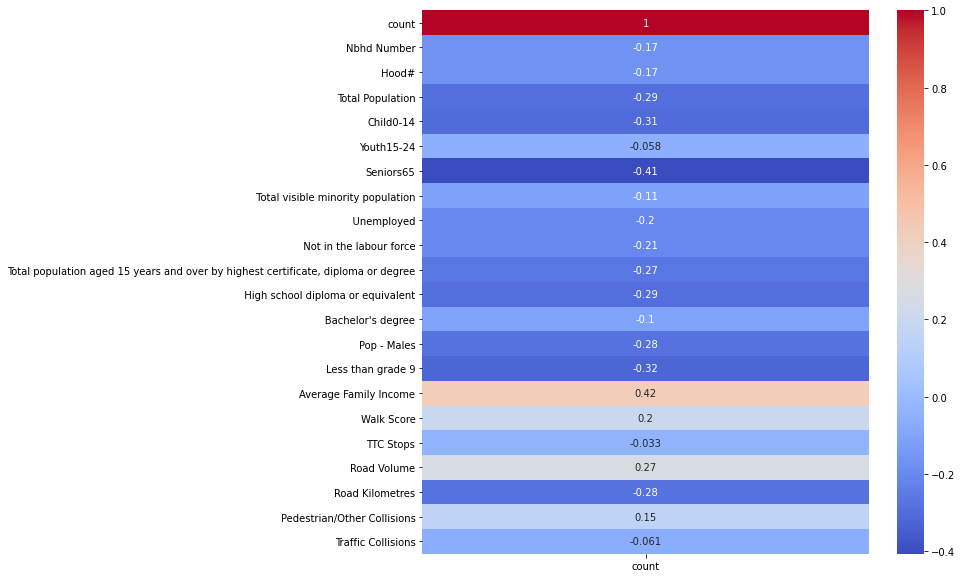

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(correls, xticklabels=correls.columns, yticklabels=correls.index, annot=True, cmap="coolwarm", ax=ax);

There's not any really strong correalations with the number of tickets, average family income seems like it could be somewhat significant

In [ ]:
correls2 = rev_nbhd_dems[rev_nbhd_dems.columns[1:]].corr()['revenue'][:-1]
correls2 = correls2.to_frame()
correls2

,revenue
revenue,1.000000
Nbhd Number,0.402111
Hood#,0.402111
Total Population,-0.344993
Child0-14,-0.604921
Youth15-24,-0.086948
Seniors65,-0.461227
Total visible minority population,-0.359181
Unemployed,-0.297051
Not in the labour force,-0.322592


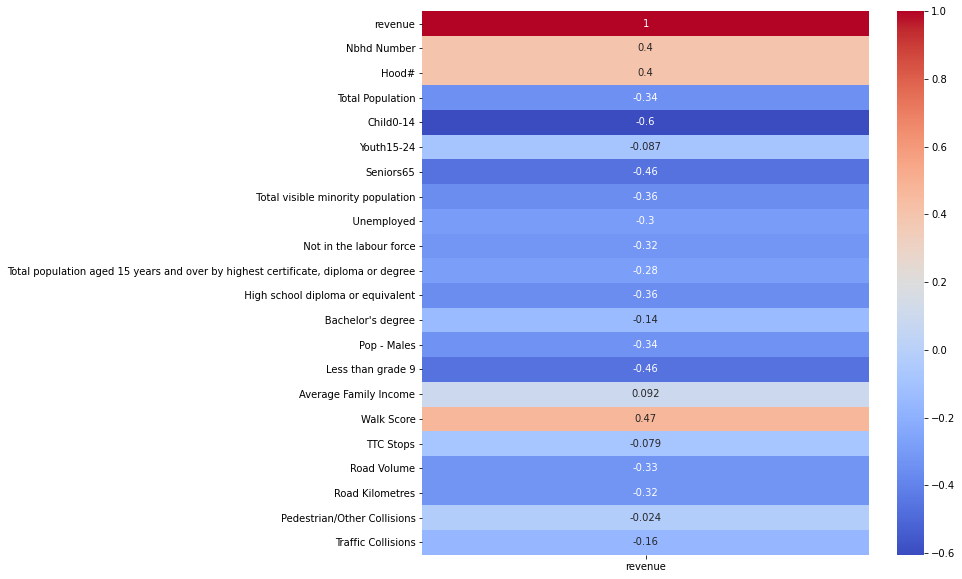

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(correls2, xticklabels=correls2.columns, yticklabels=correls2.index, annot=True, cmap="coolwarm", ax=ax);

It looks like walk score, less than grade 9, seniors65, and Children0-14 are of interest.
Let's take a look at the line of best fit

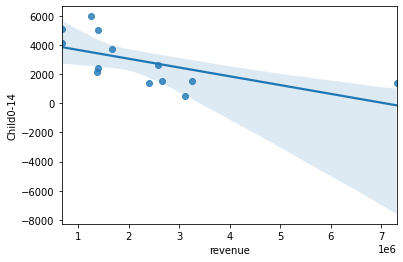

In [ ]:
#rev_nbhd_dems.plot.scatter(x='count', y='Child0-14', c='DarkBlue')
sns.regplot(x=rev_nbhd_dems['revenue'],y=rev_nbhd_dems['Child0-14']);

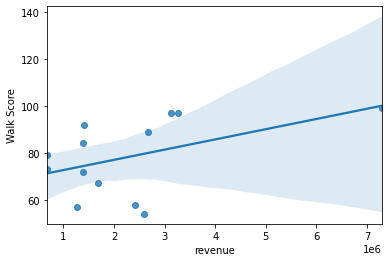

In [ ]:
sns.regplot(x=rev_nbhd_dems['revenue'],y=rev_nbhd_dems['Walk Score']);